In [33]:
# Script to clean pre-process BIOMASS INVENTORY and make spatial

# First, load packages
import pandas as pd
import os
import numpy as np
import shapely as sp
import fiona
import time

import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

import plotly.plotly as py

# only for jupyter nb to show plots inline
# %matplotlib inline 

# print("*BIOMASS PREPROCESSING SCRIPT BEGINS*")
def epsg_meters(gdf, proj=26911):
    g = gdf.copy()
    g = g.to_crs(epsg=proj)
    return g

In [4]:
#check wd
#print(os.getcwd())

#change wd
os.chdir("/Users/anayahall/projects/grapevine")

#read in biomass inventory
# GROSS inventory
gbm = pd.read_csv("data/raw/biomass.inventory.csv")

# TECHNICAL inventory
tbm = pd.read_csv("data/raw/biomass.inventory.technical.csv")

In [77]:
gbm.head()
tbm.head()

gbm.columns

# check that all counties in there
len(gbm.COUNTY.unique())
#yup, plus one "other"

59

In [78]:
# EXPLORE DATA
gbm['biomass.category'].value_counts()
# same as technical

row residue                               5900
row culls                                 4425
orchard vineyard residue                  3717
orchard vineyard culls                    3186
field residue                             2655
organic fraction municipal solid waste    2378
low moisture solids                       1947
high moisture solids                      1416
forestry                                   696
manure                                     177
Name: biomass.category, dtype: int64

In [79]:
gbm['biomass.feedstock'].value_counts().head()
# same as technical
# tbm['biomass.feedstock'].value_counts().head()

POTATO               413
OTHER CRUCIFEROUS    413
VEG OTHER            413
TOMATO & EGGPLANT    413
VEG UNSP.            413
Name: biomass.feedstock, dtype: int64

In [80]:
gbm[gbm['disposal.yields'] == gbm['disposal.yields'].max()]

,COUNTY,biomass.feedstock,disposal.yields,year,biomass.category
26027,Tulare,MANURE,2528938.639,2050,manure


In [81]:
#look at just manure (if feedstock, needs to be capitalized), if category, lower case -- should be equivalent!
gbm[(gbm['biomass.feedstock'] == "MANURE") & (gbm['year'] == 2014)].head()

,COUNTY,biomass.feedstock,disposal.yields,year,biomass.category
25856,Alameda,MANURE,30611.846700,2014,manure
25857,Alpine,MANURE,596.021083,2014,manure
25858,Amador,MANURE,28287.661520,2014,manure
25859,Butte,MANURE,31633.009850,2014,manure
25860,Calaveras,MANURE,30616.484900,2014,manure


In [82]:
#start grouping by: biomass category
gbm.groupby(['biomass.category'])['disposal.yields'].sum()

biomass.category
field residue                             5.670601e+06
forestry                                  8.363639e+07
high moisture solids                      2.878861e+06
low moisture solids                       1.527702e+07
manure                                    3.440785e+07
orchard vineyard culls                    5.222257e+05
orchard vineyard residue                  1.096371e+07
organic fraction municipal solid waste    6.297142e+07
row culls                                 1.573085e+06
row residue                               1.314184e+06
Name: disposal.yields, dtype: float64

In [83]:
gbm[gbm['biomass.category'] == "manure"].groupby(['COUNTY'])['disposal.yields'].sum().head()

COUNTY
Alameda      78386.468600
Alpine        1483.436603
Amador       71370.762600
Butte        83742.977030
Calaveras    81029.550070
Name: disposal.yields, dtype: float64

In [37]:
# now load SHAPEFILE for all CA COUNTIES to merge this
print("read in CA COUNTIES shapefile and reproject")
CA_proj = gpd.read_file("data/raw/CA_Counties/CA_Counties_TIGER2016.shp")
CA_proj.head()

CA = epsg_meters(CA_proj)
CA.head()

read in CA COUNTIES shapefile and reproject


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((186529.3218624253 4400138.485188001,..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((135777.9469054585 4293409.222963713,..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,(POLYGON ((169520.3905234018 3778880.183660138...
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((182645.5343335447 4249905.105525698,..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,(POLYGON ((254453.1051359755 3684657.954591057...


In [85]:
# type(CA)

geopandas.geodataframe.GeoDataFrame

In [38]:
# Create new geoseries of county centroids - 
# note, technically still a panda series until 'set_geomtry()' is called
CA['cocent'] = CA['geometry'].centroid
CA.tail()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,cocent
53,06,081,00277305,06081,San Mateo,San Mateo County,06,H1,G4020,488,41860,41884,A,1161658961,757412213,+37.4146633,-122.3715451,"POLYGON ((6529.833019911952 4174757.357049905,...",POINT (26033.15296345156 4156719.933127154)
54,06,093,00277311,06093,Siskiyou,Siskiyou County,06,H1,G4020,None,None,None,A,16261974847,179108278,+41.5879861,-122.5332868,"POLYGON ((13728.40879019588 4666919.137259276,...",POINT (38088.52415433052 4619500.098964834)
55,06,087,00277308,06087,Santa Cruz,Santa Cruz County,06,H1,G4020,488,42100,None,A,1152967330,419570389,+37.0124883,-122.0072050,"POLYGON ((36977.42889943934 4131515.802082703,...",POINT (54230.985876258 4109021.75288705)
56,06,021,00277275,06021,Glenn,Glenn County,06,H1,G4020,None,None,None,A,3403104376,33749275,+39.6025462,-122.4016998,POLYGON ((-5611.389011243591 4404959.816853311...,POINT (36912.07917569711 4397111.355274501)
57,06,079,00277304,06079,San Luis Obispo,San Luis Obispo County,06,H1,G4020,None,42020,None,A,8548640337,815490673,+35.3852242,-120.4475445,"POLYGON ((121724.9340142379 3969207.409139792,...",POINT (186514.7919834489 3921502.687592648)


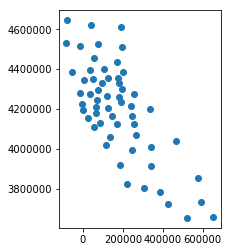

In [39]:
# both set geometry (see above) and plot to check it looks right
CA.set_geometry('cocent').plot()

In [40]:
# CREATE FIPS ID to merge with county names
#CAshape.FIPS = str(CAshape.STATEFP) + str(CAshape.COUNTYFP)
CA['FIPS']=CA['STATEFP'].astype(str)+CA['COUNTYFP']

# get rid of leading zero
CA.FIPS = [s.lstrip("0") for s in CA.FIPS]

#convert to integer for merging below
CA.FIPS = [int(i) for i in CA.FIPS]
CA.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,cocent,FIPS
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((186529.3218624253 4400138.485188001,...",POINT (197997.2356300898 4387131.095326913),6091
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((135777.9469054585 4293409.222963713,...",POINT (120813.4003770344 4264587.156989574),6067
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,(POLYGON ((169520.3905234018 3778880.183660138...,POINT (221892.1098990457 3825927.294510264),6083
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((182645.5343335447 4249905.105525698,...",POINT (188724.1567849943 4234473.909457062),6009
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,(POLYGON ((254453.1051359755 3684657.954591057...,POINT (304424.1855822782 3803702.639363075),6111


In [41]:
# NEED TO BRING IN COUNTY NAMES TO MERGE WITH BIOMASS DATA
countyIDs = pd.read_csv("data/interim/CA_FIPS.csv", names = ["FIPS", "COUNTY", "State"])
countyIDs

type(countyIDs.FIPS[0])
type(CA.FIPS[0])

CAshape = pd.merge(CA, countyIDs, on = 'FIPS')

CAshape.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,cocent,FIPS,COUNTY,State
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,...,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((186529.3218624253 4400138.485188001,...",POINT (197997.2356300898 4387131.095326913),6091,Sierra,CA
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,...,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((135777.9469054585 4293409.222963713,...",POINT (120813.4003770344 4264587.156989574),6067,Sacramento,CA
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,...,A,7084000598,2729814515,+34.5370572,-120.0399729,(POLYGON ((169520.3905234018 3778880.183660138...,POINT (221892.1098990457 3825927.294510264),6083,Santa Barbara,CA
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,...,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((182645.5343335447 4249905.105525698,...",POINT (188724.1567849943 4234473.909457062),6009,Calaveras,CA
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,...,A,4773390489,945942791,+34.3587415,-119.1331432,(POLYGON ((254453.1051359755 3684657.954591057...,POINT (304424.1855822782 3803702.639363075),6111,Ventura,CA


In [42]:
# Create subset of just county centroid points NOT POLYGONS
CAshape.head()

CA_pts = CAshape.set_geometry('cocent')[['cocent','FIPS', 'COUNTY', 'ALAND', 'AWATER']]

# type(CA_pts)

# CA_pts.plot()
# CA_pts.head()

In [91]:
# type(CAshape)

In [43]:
# now can merge with biomass data finally!!!
gbm.columns
print("merging biomass data with CA shapefile")

#POLYGONS
gbm_shp = pd.merge(CAshape, gbm, on = 'COUNTY')
# Do same for technical biomass
tbm_shp = pd.merge(CAshape, tbm, on = 'COUNTY')

# COUNTY CENTROIDS

gbm_pts = pd.merge(CA_pts, gbm, on = 'COUNTY')
tbm_pts = pd.merge(CA_pts, tbm, on = 'COUNTY')

merging biomass data with CA shapefile


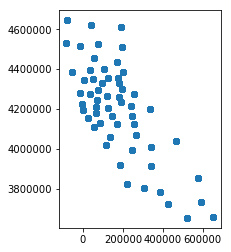

In [45]:
# tbm_pts.plot()

In [94]:
# type(tbm_shp)
# tbm_shp.tail()

# Create subset of shapefile to see it it saves any faster
# tbm_subshp = tbm_shp[tbm_shp['biomass.category'] == 'manure']

In [95]:
# type(tbm_subshp)

In [46]:
# export as SHAPEFILE

start = time.time()


print("starting export")

gbm_out = r"/Users/anayahall/projects/grapevine/data/clean/grossbiomass_pts.shp"
tbm_out = r"/Users/anayahall/projects/grapevine/data/clean/techbiomass_pts.shp"

print("saving inventories as shapefile with county centroid pts")
gbm_pts.to_file(driver='ESRI Shapefile', filename=gbm_out)
tbm_pts.to_file(driver='ESRI Shapefile', filename=tbm_out)

end = time.time()
print(end - start)



print("BIOMASS PRE_PROCESSING DONE RUNNING")

starting export
saving inventories as shapefile with county centroid pts


/Users/anayahall/anaconda/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning:

Use fiona.Env() instead.



30.78085207939148
BIOMASS PRE_PROCESSING DONE RUNNING
